# Image Classification with Convolutional Neural Networks
## by Yatharth, Michelle, and Jocelyn

 <img src="http://colah.github.io/posts/2014-07-Understanding-Convolutions/img/RiverTrain-ImageConvDiagram.png">
 <img src="http://deeplearning.net/software/theano/_images/numerical_no_padding_no_strides.gif">

# Introduction 

Here we explore CNNs for image classification. Specifically, we did this challenge
 https://www.kaggle.com/c/dogs-vs-cats/data

Let's first add all the imports we need and then talk about some background

In [1]:
import os

import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.misc import toimage

%matplotlib inline

# Background

## Understanding Convolutions

To understand convolutions, we wrote a function that uses a 3x3 filter matrix to perform a convolution on another matrix

In [95]:
def convolve(data, matrix):
    arr = []
    for r in range(len(data[0])-len(matrix[0])+1):
        for c in range(len(data) - len(matrix) + 1):
            new_matrix = np.array([data[r][c:c+len(matrix)],data[r+1][c:c+len(matrix)],data[r+2][c:c+len(matrix)]])
            sm = 0
            for r1 in range(len(new_matrix)):
                for c1 in range(len(new_matrix)):
                    sm = sm + new_matrix[r1][c1]*matrix[r1][c1]
            arr.append(sm)
    arr = np.array(arr)
    arr = arr.reshape(int(len(arr)**.5),int(len(arr)**.5))
    return(arr)

data = np.array([[0, -.25, 0, 5, 6, 7],[-0.25, 2, 3, 1, -0.25, 7],[0,4, 6,-0.25,0, 8],[0,4, 6,-0.25,0, 9],[0,4, 6,-0.25,0, 10],[1,2,3,4,5,6]])
matrix1 = np.array([[0, -.25, 0],[-0.25, 1, -0.25],[0,-0.25,0]])
matrix2 = np.array([[(-1.0/9), (-1.0/9), (-1.0/9)],[(-1.0/9), 1, (-1.0/9)],[(-1.0/9),(-1.0/9),(-1.0/9)]])
 
print(data)
print(convolve(data, matrix1))
print(convolve(data, matrix2))

[[  0.    -0.25   0.     5.     6.     7.  ]
 [ -0.25   2.     3.     1.    -0.25   7.  ]
 [  0.     4.     6.    -0.25   0.     8.  ]
 [  0.     4.     6.    -0.25   0.     9.  ]
 [  0.     4.     6.    -0.25   0.    10.  ]
 [  1.     2.     3.     4.     5.     6.  ]]
[[ 0.375   0.75   -0.875  -3.75  ]
 [ 1.      2.8125 -1.9375 -1.875 ]
 [ 0.5     2.0625 -1.625  -2.1875]
 [ 1.      2.8125 -2.6875 -3.6875]]
[[ 0.61111111  1.05555556 -1.16666667 -4.        ]
 [ 1.69444444  3.83333333 -1.97222222 -2.69444444]
 [ 1.11111111  3.41666667 -2.19444444 -2.91666667]
 [ 1.55555556  3.5        -2.88888889 -3.72222222]]


## Using and Understanding Keras

We decided to train our convolutional neural network with Keras, so we found the following code after installing Keras so we could test it and see how to train a model on the MNIST data.

In our model, we had 32 convolutional filters and a pool size of 2x2. We used the rectified linear unit function for our nonlinearity. 

In [13]:
import MNIST

Using data shape (60000, 28, 28, 1)
Loading previously saved model
Evaluating model on 10000 test samples
Test Score: 0.0327079413274
Test Accuracy: 0.9891


Pretty good! Let’s move on to the real thing.

# The Cats versus Dogs Challenge

## Stage 0: Downloading the Data 

First we downloaded the files from Kaggle into the rawdata directory (not included in the submission as there's a lot). 
Then we made a data directory with the following structure

data/
    train/
        cats/
            cat.0.jpg
            cat.1.jpg
            ...
            cat.1999.jpg
        dogs/
            dog.0.jpg
            dog.1.jpg
            ...
            dog.1999.jpg
    validate/
        cats/
            cat.12000.jpg
            cat.12001.jpg
            ...
            cat.12499.jpg
        dogs/
            dog.12000.jpg
            dog.12001.jpg
            ...
            dog.12499.jpg

We did this processing of data for two reasons:
(a) to make it very difficult for ourselves to accidentially contaminate our model with the validation data
(b) to make it easier to load images from the directories using `flow_from_directory` 
(c) use only 2000 of the 25000 images for each class to train
   (i) This made training go quicker.
   (ii) We also just wanted to give ourselves more of a challenge :)

Here are some cats:


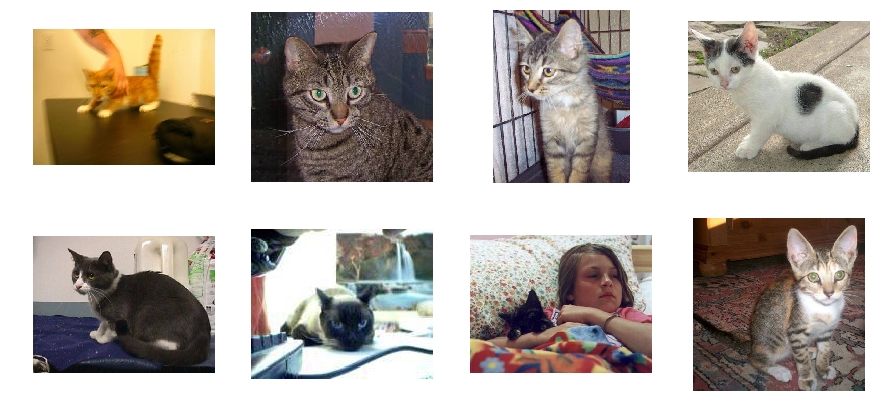

And now, some dogs:


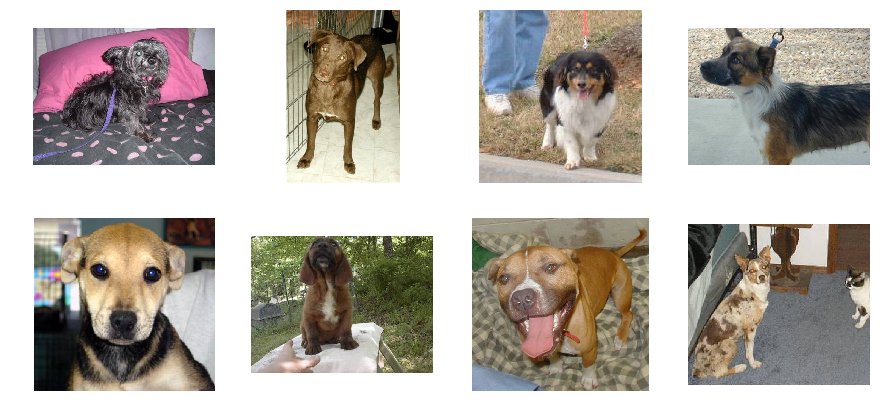

In [79]:
CAT, DOG = 'cat', 'dog'

def demo_images(cls):
    
    assert cls in (CAT, DOG)
    
    WIDTH, HEIGHT = 4, 2

    fig, axes = plt.subplots(HEIGHT, WIDTH)
    fig.set_figwidth(15)
    fig.set_figheight(7)
    
    for i in range(WIDTH * HEIGHT):
        ax = axes[i // WIDTH][i % WIDTH]
        img = mpimg.imread('data/train/{}s/{}.{}.jpg'.format(cls, cls, i))
        ax.imshow(img)
        ax.axis('off')
        
    plt.show()
    
print("Here are some cats:")
demo_images(CAT)
print("And now, some dogs:")
demo_images(DOG)

## Stage 1: Initial Testing
We first wanted to do an initial test to familiarize ourselves with Keras and such.
After training, saving the weights and loading the weights we trained our neural network overnight on server to use 16 CPUs. This is why you don't see the training done here.

In [2]:
import stage1

Using TensorFlow backend.


Starting up...
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Loading weights from stage1.h5...
Accuracy: 64.50%


It works! Doesn't do great though: Not much better than 50%. Let's look at some more statistics:

In [4]:
print("Accuracy on training data: %.2f%%" % (
    100 * stage1.model.evaluate_generator(stage1.train_generator, val_samples=stage1.NB_TRAIN_SAMPLES)[1]
))

print("Accuracy on validation data: %.2f%%" % (
    100 * stage1.model.evaluate_generator(stage1.validate_generator, val_samples=stage1.NB_VALIDATE_SAMPLES)[1]
))

Accuracy on training data: 95.67%
Accuracy on validation data: 64.50%


Our accuracy on the validation data is much lower than that of the training data, which means we’re overfitting. This is one of the problems of applying deep learning: finding enough data. We could always use more data from the Kaggle contest, but what if we didn’t have that? Below is the solution to this issue.

## Stage 2: Data Augmentation

Data Augmention allows us to build better models by creating more data by rotating, mirroring, changing contrast, and performing other modifications on your existing data to make "new" images. 

In [2]:
import stage2

Using TensorFlow backend.


Starting up...
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Loading weights from stage2.h5...
Accuracy: 82.70%


We also started keeping track of accuracies on the training and validation datasets over time:

In [9]:
def read_hist(stage_number):
    filename = 'stage{}.log'.format(stage_number)
    with open(filename) as logfile:
        full_history = eval(logfile.read())
        
    epochs = len(full_history['acc'])
    POINTS = 15
    
    acc = full_history['acc'][::epochs // POINTS]
    val_acc =  full_history['val_acc'][::epochs // POINTS]
    
    return acc, val_acc

def print_hist(hist):
    for name, vals in zip(["acc", "val"], hist):
        print("{}:".format(name), " ".join("%d%%" % round(elem * 100) for elem in vals))

In [3]:
print_hist(read_hist(2))

acc: 54% 69% 74% 76% 78% 79% 81% 81% 82% 82% 83% 84% 83% 84% 84% 84% 85%
val: 62% 72% 75% 76% 80% 80% 80% 82% 80% 82% 82% 82% 83% 83% 81% 83% 80%


We observed a huge jump: 15 percentage points! There’s still a slight disparity in the training ans validation accuracies, so let’s try to reduce overfitting with a different method.

## Stage 3: Dropout

Dropout is a regularization technique for neural networks to prevent overfitting. It works by randomly selecting neurons to drop out of the training process

In [5]:
import stage3

Starting up...
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Loading weights from stage3.h5...
Accuracy: 82.40%


In [6]:
print_hist(read_hist(3))

acc: 55% 69% 75% 77% 79% 79% 80% 80% 82% 82% 82% 82% 82% 82% 82% 83% 83%
val: 59% 75% 76% 78% 78% 81% 81% 80% 80% 82% 80% 81% 80% 79% 73% 82% 83%


Our accuracy didn’t change by much, so now let’s try making our model more complex.

## Stage 4: Making the model more Complex

We add more convolutional layers, activation layers, dropout layers, and pooling layers, as suggested by http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/

In [2]:
import stage4

Using TensorFlow backend.


Starting up...
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Loading weights from stage4.h5...
Accuracy: 50.00%


What's going on? Let’s look at the history.

In [10]:
print_hist(read_hist(4))

acc: 50% 50% 50% 50% 50% 50% 50% 50% 50% 49% 50% 50% 50% 50% 49% 50% 50%
val: 50% 50% 49% 50% 50% 51% 48% 50% 50% 51% 50% 51% 49% 49% 50% 51% 48%


 This low accuracy may be due to the fact that we're not training our model for long enough given its complexity. In this case, we can stick to our earlier model. 

# Conclusion

Years ago, an accuracy of 60% alone would be awesome. Today, we reached an accuracy of 80% easily without tuning hyperparameters, using just 2000/25000 = 8% of the data. State of the art pushes this percentage up to 98% or something like that. CNNs definitely show improvement. 
## Future Directions

1. Transfer Learning. Explain what it is and how it works.
1. Regularizing w_norms in dense layer
1. SGD for faster convergence

## References

Gentle Introductions: https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/ and https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks-Part-2/ 

Needlessly Complicated Introduction: https://colah.github.io/posts/2014-07-Conv-Nets-Modular/ and https://colah.github.io/posts/2014-07-Understanding-Convolutions/ 

Okay Animation: https://www.youtube.com/watch?v=jajksuQW4mc

Visualizing Deep Networks: https://www.youtube.com/watch?v=AgkfIQ4IGaM 

How to use Keras: http://machinelearningmastery.com/tutorial-first-neural-network-python-keras/ 